In [3]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

F:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
os.getcwd()

'C:\\Users\\Rakesh Chauhan\\Documents\\2nd Sem\\Dissertation'

In [4]:
train_variants_df = pd.read_csv("training_variants")
test_variants_df = pd.read_csv("test_variants")
train_text_df = pd.read_csv("training_text", sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
test_text_df = pd.read_csv("test_text", sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])

In [5]:
print("Train Variant".ljust(15), train_variants_df.shape)
print("Train Text".ljust(15), train_text_df.shape)
print("Test Variant".ljust(15), test_variants_df.shape)
print("Test Text".ljust(15), test_text_df.shape)

Train Variant   (3321, 4)
Train Text      (3321, 2)
Test Variant    (5668, 3)
Test Text       (5668, 2)


In [6]:
train_variants_df.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [7]:
train_variants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [8]:
train_text_df.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [9]:
train_text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
Text    3321 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [10]:
train_variants_df.columns

Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object')

In [11]:
train_variants_df.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [12]:
#train_variants_df.Gene = train_variants_df.Gene.astype('category')

In [13]:
#len(train_variants_df.Gene.cat.categories)

In [14]:
train_variants_df.Class = train_variants_df.Class.astype('category')

In [15]:
len(train_variants_df.Class.cat.categories)

9

In [16]:
train_variants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null category
dtypes: category(1), int64(1), object(2)
memory usage: 81.2+ KB


In [17]:
print("For training data, there are a total of",
len(train_variants_df.ID.unique()), "IDs,", end='')
print(len(train_variants_df.Gene.unique()), "unique genes,", end='')
print(len(train_variants_df.Variation.unique()), "unique variations and ", end='')
print(len(train_variants_df.Class.unique()),  "classes")

For training data, there are a total of 3321 IDs,264 unique genes,2996 unique variations and 9 classes


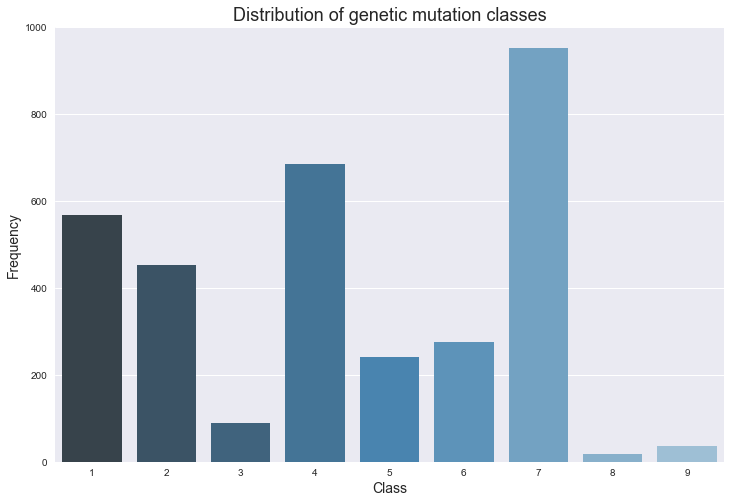

In [18]:
plt.figure(figsize=(12,8))
sns.countplot(x='Class', data=train_variants_df, palette="Blues_d")
plt.ylabel('Frequency', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.title('Distribution of genetic mutation classes', fontsize=18)
plt.show()

In [19]:
gene_group = train_variants_df.groupby("Gene")['Gene'].count()
minimal_occ_genes = gene_group.sort_values(ascending=True)[:10]
print("Genes with maximal occurances\n",
     gene_group.sort_values(ascending=False)[:10])
print("\nGenes with minimal occurances\n", minimal_occ_genes)

Genes with maximal occurances
 Gene
BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
KIT        99
BRAF       93
ERBB2      69
ALK        69
PDGFRA     60
Name: Gene, dtype: int64

Genes with minimal occurances
 Gene
KLF4      1
FGF19     1
FANCC     1
FAM58A    1
PAK1      1
ERRFI1    1
PAX8      1
PIK3R3    1
PMS1      1
PPM1D     1
Name: Gene, dtype: int64


some genes that has highest number of occurrences in each class

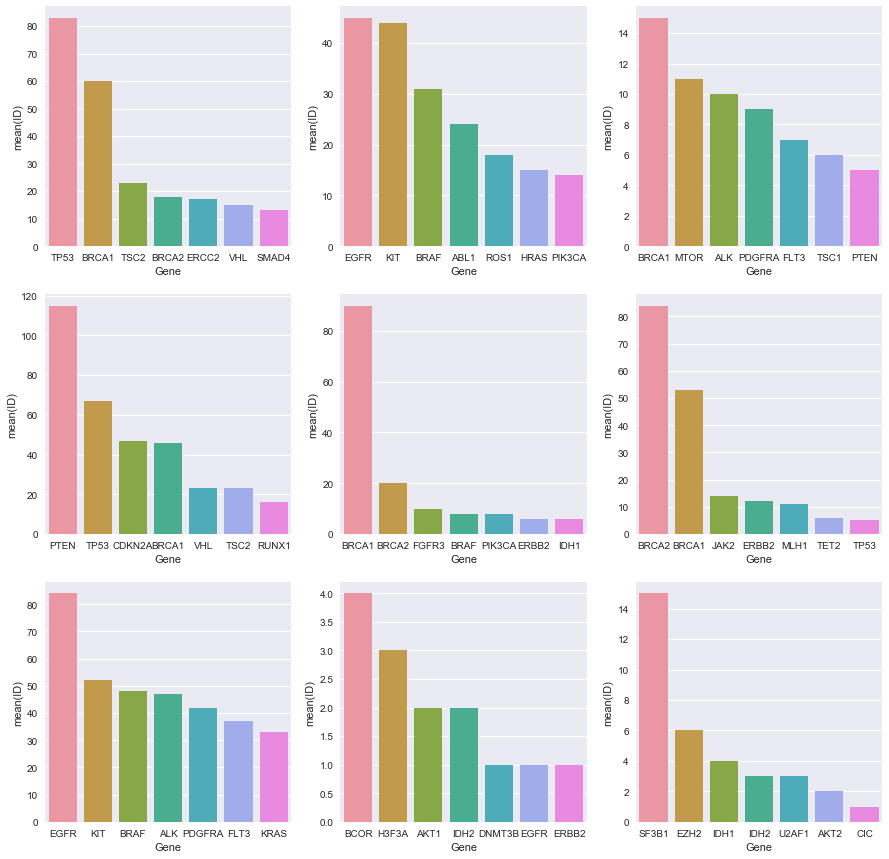

In [20]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        gene_count_grp = train_variants_df[train_variants_df["Class"]==\
                                          ((i*3+j)+1)].groupby('Gene')['ID']\
        .count().reset_index()
        sorted_gene_group = gene_count_grp.sort_values('ID', ascending=False)
        sorted_gene_group_top_7 = sorted_gene_group[:7]
        sns.barplot(x="Gene", y="ID", data=sorted_gene_group_top_7,\
                    ax=axs[i][j])

Some points we can conclude from these graphs:

1.BRCA1 is highly dominating Class 5

2.SF3B1 is highly dominating Class 9

3.BRCA1 and BRCA2 are dominating Class 6

# Text data

In [21]:
train_text_df.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [22]:
train_text_df.loc[:, 'Text Count'] = train_text_df["Text"].\
apply(lambda x: len(x.split()))
train_text_df.head()

,ID,Text,Text Count
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,6089
1,1,Abstract Background Non-small cell lung canc...,5722
2,2,Abstract Background Non-small cell lung canc...,5722
3,3,Recent evidence has demonstrated that acquired...,5572
4,4,Oncogenic mutations in the monomeric Casitas B...,6202


#### combining both dataframes

In [23]:
train_full = train_variants_df.merge(train_text_df, how='inner', \
                                    left_on='ID', right_on='ID')
train_full[train_full['Class']==1].head()

,ID,Gene,Variation,Class,Text,Text Count
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,6089
7,7,CBL,Deletion,1,CBL is a negative regulator of activated recep...,14684
16,16,CBL,Truncating Mutations,1,To determine if residual cylindrical refractiv...,8118
37,37,DICER1,D1709E,1,Sex cordâ€“stromal tumors and germ-cell tumors...,2710
38,38,DICER1,D1709A,1,Sex cordâ€“stromal tumors and germ-cell tumors...,2710


In [24]:
for i in list(range(1,10)):
    print(train_full[train_full['Class']==i].head())

    ID    Gene             Variation  Class  \
0    0  FAM58A  Truncating Mutations      1   
7    7     CBL              Deletion      1   
16  16     CBL  Truncating Mutations      1   
37  37  DICER1                D1709E      1   
38  38  DICER1                D1709A      1   

                                                 Text  Text Count  
0   Cyclin-dependent kinases (CDKs) regulate a var...        6089  
7   CBL is a negative regulator of activated recep...       14684  
16  To determine if residual cylindrical refractiv...        8118  
37  Sex cordâ€“stromal tumors and germ-cell tumors...        2710  
38  Sex cordâ€“stromal tumors and germ-cell tumors...        2710  
    ID   Gene      Variation  Class  \
1    1    CBL          W802*      2   
2    2    CBL          Q249E      2   
33  33   TERT  Amplification      2   
71  71  CCND2  Amplification      2   
75  75  CCND3  Amplification      2   

                                                 Text  Text Count  
1    A

#### there are multiple rows with similar text, checking how many of them are unique and whether all similar texts belong to same class

In [28]:
count_grp = train_full.groupby('Class')['Text Count']
count_grp.describe()

Class       
1      count      568.000000
       mean      9444.705986
       std       6513.636387
       min          1.000000
       25%       4970.000000
       50%       7286.500000
       75%      12868.250000
       max      52970.000000
2      count      452.000000
       mean      9306.362832
       std       7624.322787
       min        116.000000
       25%       4184.250000
       50%       6810.000000
       75%      12209.500000
       max      61923.000000
3      count       89.000000
       mean      6751.157303
       std       3724.432760
       min       1737.000000
       25%       4283.000000
       50%       5572.000000
       75%       7415.000000
       max      27371.000000
4      count      686.000000
       mean      8978.202624
       std       7276.259637
       min         53.000000
       25%       4566.000000
       50%       6351.000000
                    ...     
6      std       3827.975473
       min          1.000000
       25%       4505.500000
 

In [29]:
#Some entries have text count 1.

In [8]:
train_full[train_full["Text Count"]==1.0]

,ID,Gene,Variation,Class,Text,Text Count
1109,1109,FANCA,S1088F,1,null,1
1277,1277,ARID5B,Truncating Mutations,1,null,1
1407,1407,FGFR3,K508M,6,null,1
1639,1639,FLT1,Amplification,6,null,1
2755,2755,BRAF,G596C,7,null,1


In [9]:
train_full[train_full["Text Count"]<500.0]

,ID,Gene,Variation,Class,Text,Text Count
140,140,EGFR,I491M,5,The accurate determination of perfluoroalkyl s...,430
145,145,EGFR,K467T,2,The accurate determination of perfluoroalkyl s...,430
259,259,EGFR,S464L,2,The accurate determination of perfluoroalkyl s...,430
344,344,CDH1,A617T,4,E-cadherin is involved in the formation of cel...,187
346,346,CDH1,A634V,4,E-cadherin is involved in the formation of cel...,187
348,348,CDH1,T340A,4,E-cadherin is involved in the formation of cel...,187
648,648,CDKN2A,Q50*,4,"The p16 gene is located in chromosome 9p21, a ...",103
688,688,CDKN2A,R79P,4,Cell division is controlled by a series of pos...,228
692,692,CDKN2A,G93W,4,Cell division is controlled by a series of pos...,228
693,693,CDKN2A,V118D,4,Cell division is controlled by a series of pos...,228


some enteries don't have any text data. distribution of text count for each class:

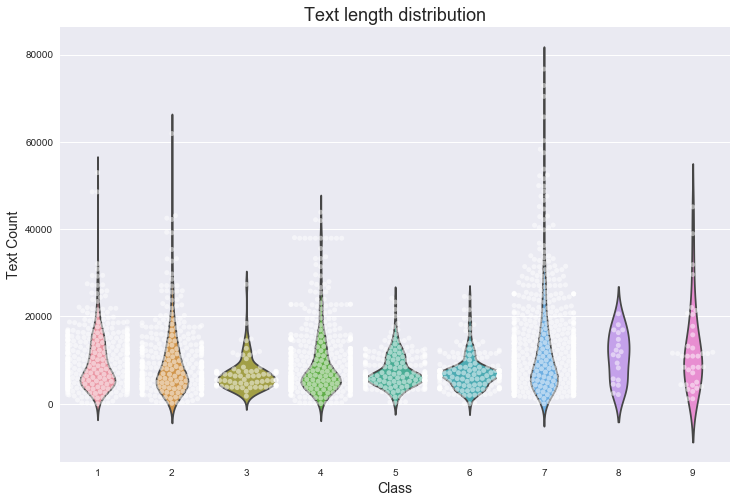

In [10]:
plt.figure(figsize=(12,8))
gene_count_grp = train_full.groupby('Gene')['Text Count'].sum().reset_index()
sns.violinplot(x='Class', y='Text Count', data=train_full, inner=None)
sns.swarmplot(x="Class", y="Text Count", data=train_full, color="w", alpha=.5);
plt.ylabel('Text Count', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.title("Text length distribution", fontsize=18)
plt.show()

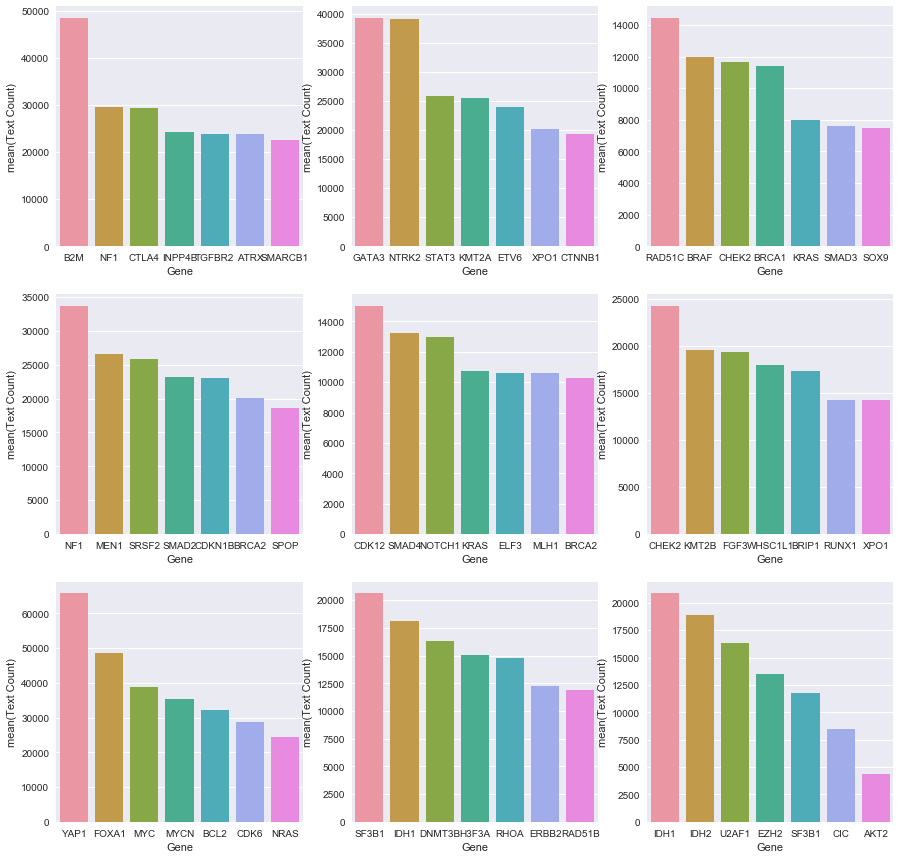

In [11]:
fog, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        gene_count_grp = train_full[train_full["Class"]==((i*3+j)+1)]\
        .groupby('Gene')["Text Count"].mean().reset_index()
        sorted_gene_group = gene_count_grp.sort_values('Text Count',\
                                                       ascending=False)
        sorted_gene_group_top_7 = sorted_gene_group[:7]
        sns.barplot(x="Gene", y="Text Count", data=sorted_gene_group_top_7,\
                    ax=axs[i][j])

In [40]:
def top_tfidf_feats(row, features, top_n=10):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=10):
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=10):
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=10):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(12, 100), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        #z = int(str(int(i/3)+1) + str((i%3)+1))
        ax = fig.add_subplot(9, 1, i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=16)
        ax.set_ylabel("Gene", labelpad=16, fontsize=16)
        ax.set_title("Class = " + str(df.label), fontsize=18)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [41]:
tfidf = TfidfVectorizer(min_df=5, max_features=16000, strip_accents='unicode',lowercase =True,
analyzer='word', token_pattern=r'\w+', use_idf=True, 
smooth_idf=True, sublinear_tf=True, stop_words = 'english').fit(train_full["Text"])

Xtr = tfidf.fit_transform(train_full["Text"])
y = train_full["Class"]
features = tfidf.get_feature_names()
top_dfs = top_feats_by_class(Xtr, y, features)

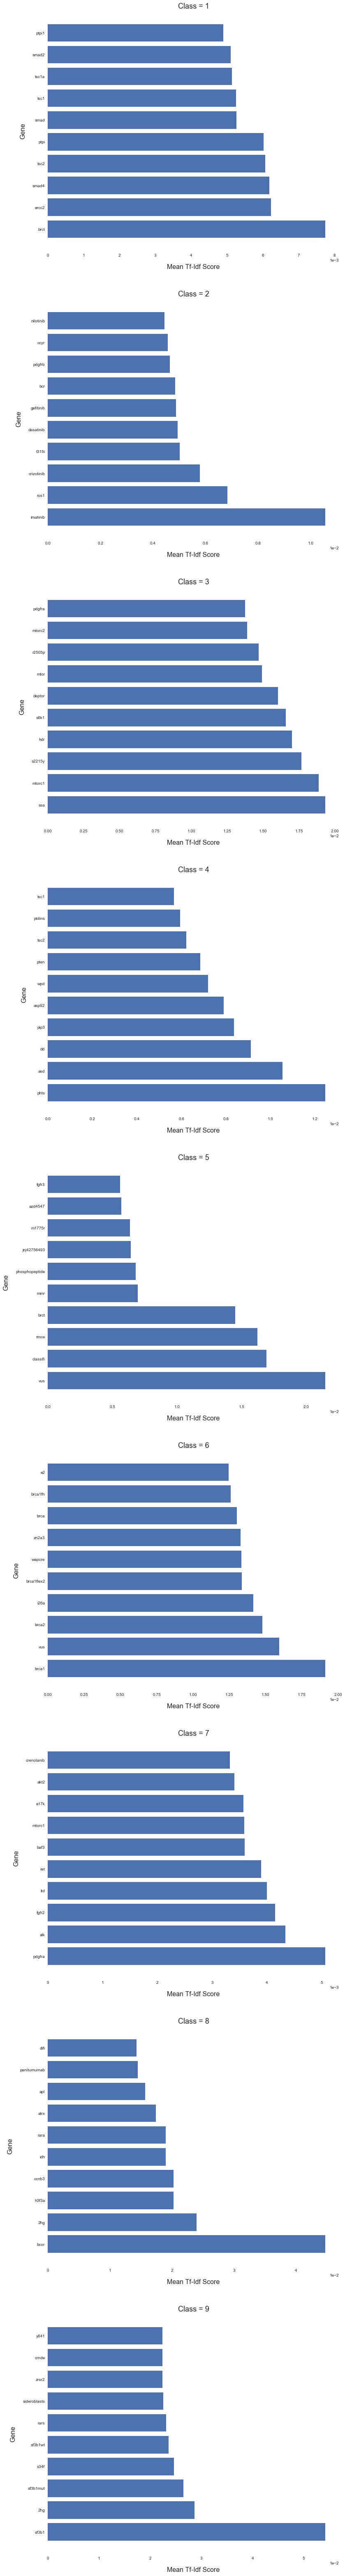

In [42]:
plot_tfidf_classfeats_h(top_dfs)

# Wordclouds

In [25]:
%matplotlib inline
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [36]:
STOPWORDS.add('et')
STOPWORDS.add('al')
STOPWORDS.add('â')
STOPWORDS.add('Figure')
STOPWORDS.add('figure')
STOPWORDS.add('fig')
STOPWORDS.add('Supplementary')
STOPWORDS.add('cell')
STOPWORDS.add('cancer')
STOPWORDS.add('mutation')
STOPWORDS.add('variant')
STOPWORDS.add('patient')
STOPWORDS.add('tumor')
STOPWORDS.add('table')
STOPWORDS.add('data')
STOPWORDS.add('analysis')
STOPWORDS.add('study')
STOPWORDS.add('method')
STOPWORDS.add('result')
STOPWORDS.add('author')
STOPWORDS.add('conclusion')
STOPWORDS.add('find')
STOPWORDS.add('found')
STOPWORDS.add('show')
STOPWORDS.add('perform')
STOPWORDS.add('demonstrate')
STOPWORDS.add('evaluate')
STOPWORDS.add('discuss')
STOPWORDS.add('mutations')
STOPWORDS.add('variants')
STOPWORDS.add('cells')
STOPWORDS.add('patients')
STOPWORDS.add('protein')
STOPWORDS.add('gene')
STOPWORDS.add('mutant')

In [37]:
class1DF = train_full[train_full.Class == 1]
class2DF = train_full[train_full.Class == 2]
class3DF = train_full[train_full.Class == 3]
class4DF = train_full[train_full.Class == 4]
class5DF = train_full[train_full.Class == 5]
class6DF = train_full[train_full.Class == 6]
class7DF = train_full[train_full.Class == 7]
class8DF = train_full[train_full.Class == 8]
class9DF = train_full[train_full.Class == 9]

In [38]:
class1 = class1DF['Text'].tolist()
string1 = ''
for i in range(len(class1)):
    string1 += class1[i]

class2 = class2DF['Text'].tolist()
string2 = ''
for i in range(len(class2)):
    string2 += class2[i]

class3 = class3DF['Text'].tolist()
string3 = ''
for i in range(len(class3)):
    string3 += class3[i]

class4 = class4DF['Text'].tolist()
string4 = ''
for i in range(len(class4)):
    string4 += class4[i]

class5 = class5DF['Text'].tolist()
string5 = ''
for i in range(len(class5)):
    string5 += class5[i]

class6 = class6DF['Text'].tolist()
string6 = ''
for i in range(len(class6)):
    string6 += class6[i]

class7 = class7DF['Text'].tolist()
string7 = ''
for i in range(len(class7)):
    string7 += class7[i]

class8 = class8DF['Text'].tolist()
string8 = ''
for i in range(len(class8)):
    string8 += class8[i]

class9 = class9DF['Text'].tolist()
string9 = ''
for i in range(len(class9)):
    string9 += class9[i]

In [39]:
wordcloud1 = WordCloud(   stopwords=STOPWORDS,
                          background_color='white',

                       max_words=25
                         ).generate(string1)

wordcloud2 = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',

                        max_words=25
                         ).generate(string2)

wordcloud3 = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',

                        max_words=25
                         ).generate(string3)

wordcloud4 = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',

                        max_words=25
                         ).generate(string4)

wordcloud5 = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',

                        max_words=25
                         ).generate(string5)

wordcloud6 = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',

                        max_words=25
                         ).generate(string6)

wordcloud7 = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',

                        max_words=25
                         ).generate(string7)

wordcloud8 = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',

                        max_words=25
                         ).generate(string8)

wordcloud9 = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='white',

                        max_words=25
                         ).generate(string9)

Class 1


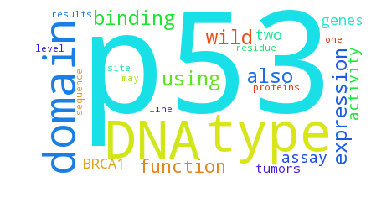

Class 2


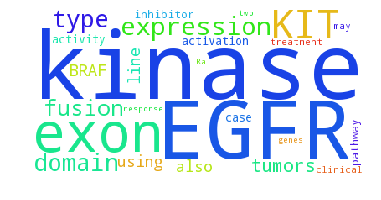

Class 3


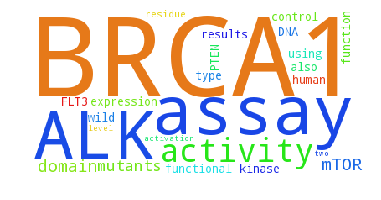

Class 4


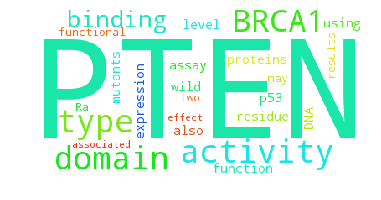

Class 5


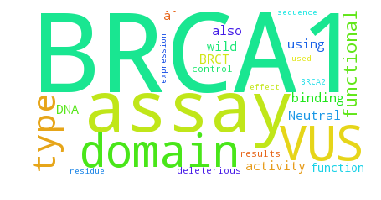

Class 6


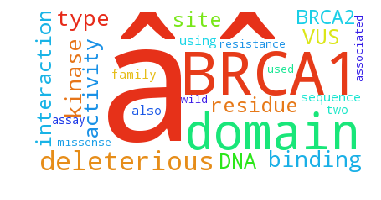

Class 7


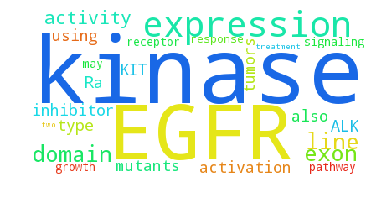

Class 8


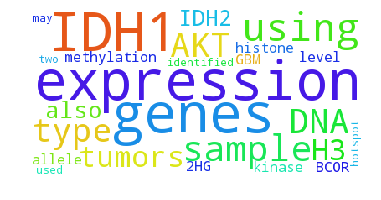

Class 9


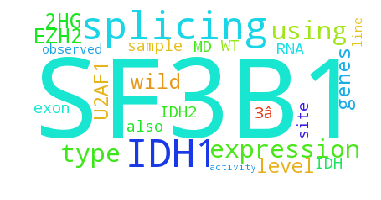

In [40]:
print("Class 1")
plt.imshow(wordcloud1)
plt.axis('off')
plt.show()

print("Class 2")
plt.imshow(wordcloud2)
plt.axis('off')
plt.show()

print("Class 3")
plt.imshow(wordcloud3)
plt.axis('off')
plt.show()

print("Class 4")
plt.imshow(wordcloud4)
plt.axis('off')
plt.show()

print("Class 5")
plt.imshow(wordcloud5)
plt.axis('off')
plt.show()

print("Class 6")
plt.imshow(wordcloud6)
plt.axis('off')
plt.show()

print("Class 7")
plt.imshow(wordcloud7)
plt.axis('off')
plt.show()

print("Class 8")
plt.imshow(wordcloud8)
plt.axis('off')
plt.show()

print("Class 9")
plt.imshow(wordcloud9)
plt.axis('off')
plt.show()

---

In [1]:
import numpy as np
import pandas as pd

from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from nltk.corpus import stopwords
import re
import gc

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

F:\Anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
train_variants_df = pd.read_csv("training_variants")
test_variants_df = pd.read_csv("test_variants")
train_text_df = pd.read_csv("training_text", sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
test_text_df = pd.read_csv("test_text", sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])

In [3]:
train_variants_df.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
train_text_df.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [3]:
print(train_text_df['Text'][0][:100], '  ', len(train_text_df['Text'][0]))

Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands o    39765


Each row can be treated as a seperate document because of the length of the text in them

In [8]:
varsGeneCount = Counter(train_variants_df.Gene)
print(len(varsGeneCount))

264


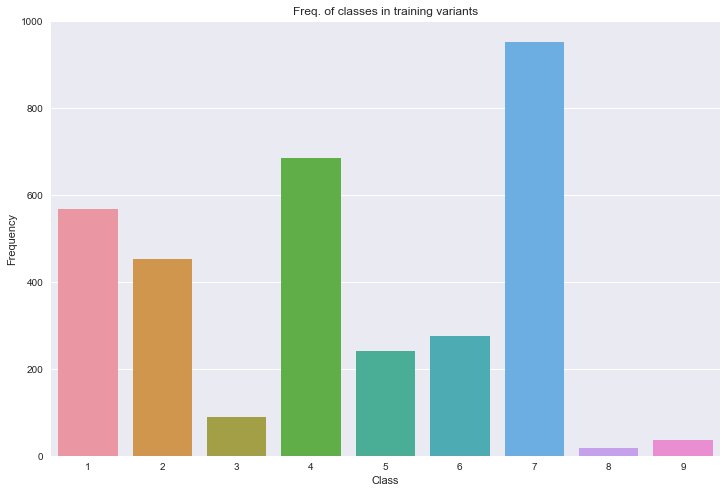

In [11]:
plt.figure(figsize=(12,8))
ax = sns.countplot(x='Class', data=train_variants_df)
plt.ylabel('Frequency')
plt.xlabel('Class')
plt.title('Freq. of classes in training variants')
plt.show()

Instances of class 7 and 4 have higher frequency and instances of class 3 8 and 9 have lower frequencies. This means in this multivariate model, there is some kind of skewness being introduced by class 7 and class 4. 

In [12]:
varsVariationCount = Counter(train_variants_df.Variation)
print('Number of unique variaitons in training data\n', len(varsVariationCount))

Number of unique variaitons in training data
 2996


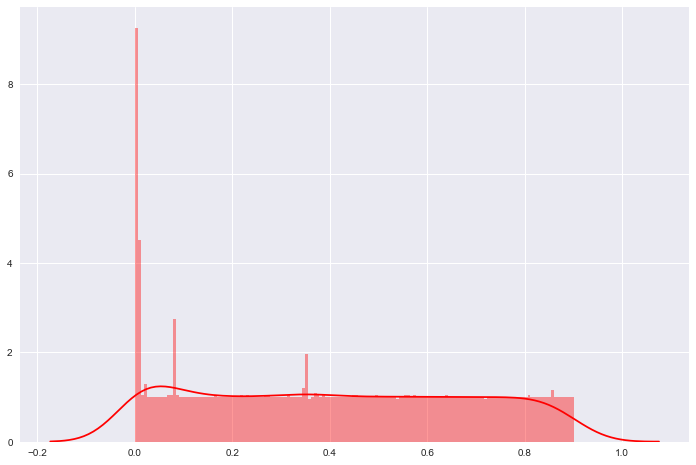

In [16]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax = sns.distplot(pd.factorize(train_variants_df['Variation'])[0]/\
                  len(train_variants_df), bins=150, color='r')

There are many different categories in this training set, there are a lot of uniqiue variaitons with only 1 count. 

In [4]:
def textClean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stopw = {'so', 'his', 't', 'y', 'ours', 'herself', 
             'your', 'all', 'some', 'they', 'i', 'of', 'didn', 
             'them', 'when', 'will', 'that', 'its', 'because', 
             'while', 'those', 'my', 'don', 'again', 'her', 'if',
             'further', 'now', 'does', 'against', 'won', 'same', 
             'a', 'during', 'who', 'here', 'have', 'in', 'being', 
             'it', 'other', 'once', 'itself', 'hers', 'after', 're',
             'just', 'their', 'himself', 'theirs', 'whom', 'then', 'd', 
             'out', 'm', 'mustn', 'where', 'below', 'about', 'isn',
             'shouldn', 'wouldn', 'these', 'me', 'to', 'doesn', 'into',
             'the', 'until', 'she', 'am', 'under', 'how', 'yourself',
             'couldn', 'ma', 'up', 'than', 'from', 'themselves', 'yourselves',
             'off', 'above', 'yours', 'having', 'mightn', 'needn', 'on', 
             'too', 'there', 'an', 'and', 'down', 'ourselves', 'each',
             'hadn', 'ain', 'such', 've', 'did', 'be', 'or', 'aren', 'he', 
             'should', 'for', 'both', 'doing', 'this', 'through', 'do', 'had',
             'own', 'but', 'were', 'over', 'not', 'are', 'few', 'by', 
             'been', 'most', 'no', 'as', 'was', 'what', 's', 'is', 'you', 
             'shan', 'between', 'wasn', 'has', 'more', 'him', 'nor',
             'can', 'why', 'any', 'at', 'myself', 'very', 'with', 'we', 
             'which', 'hasn', 'weren', 'haven', 'our', 'll', 'only',
             'o', 'before',"fig", "figure", "et", "al", "table", "data", 
             "analysis", "analyze", "study","method", "result", "conclusion",
             "author", "find", "found", "show", "perform", "demonstrate", "evaluate", 
             "discuss", 'et',"al","â","Figure","figure","fig","Supplementary","cell",
             "cancer","mutation","variant","patient","tumor","table","data","analysis",
             "study","method","result","author","conclusion","find","found","show","perform",
             "demonstrate","evaluate","discuss","mutations","variants","cells","patients",
             "protein","gene","mutant"}
    text = [w for w in text if not w in stopw]    
    text = " ".join(text)
    text = text.replace("."," ").replace(","," ")
    return(text)

In [5]:
trainText = []
for it in train_text_df['Text']:
    newText = textClean(it)
    trainText.append(newText)
testText = []
for it in test_text_df['Text']:
    newText = textClean(it)
    testText.append(newText)

In [6]:
trainText[0][:100]

'cyclin-dependent kinases cdks regulate variety fundamental cellular processes  cdk10 stands one last'

Somewhat the documents are clean, which can be further filtered by adding more stopwords to the list created above. Let's check some of the documents and see the most common words in each doc

In [7]:
for i in range(10):
    print('\n Doc', str(i))
    stopCheck = Counter(trainText[i].split())
    print(stopCheck.most_common()[:10])


 Doc 0
[('cyclin', 90), ('cdk10', 81), ('fig', 68), ('ets2', 54), ('expression', 43), ('1', 42), ('levels', 35), ('star', 33), ('fam58a', 33), ('2', 32)]

 Doc 1
[('c-cbl', 153), ('lung', 56), ('egfr', 43), ('1', 41), ('samples', 33), ('met', 33), ('0', 29), ('5', 29), ('loh', 29), ('using', 24)]

 Doc 2
[('c-cbl', 153), ('lung', 56), ('egfr', 43), ('1', 41), ('samples', 33), ('met', 33), ('0', 29), ('5', 29), ('loh', 29), ('using', 24)]

 Doc 3
[('cbl', 104), ('cases', 50), ('aupd', 42), ('upn', 38), ('2', 34), ('3', 29), ('case', 26), ('11q', 25), ('5', 25), ('tyrosine', 22)]

 Doc 4
[('cbl', 121), ('binding', 64), ('stability', 40), ('effects', 33), ('1', 32), ('fig', 32), ('activity', 30), ('cbl-e2', 30), ('state', 26), ('0', 24)]

 Doc 5
[('cbl', 121), ('binding', 64), ('stability', 40), ('effects', 33), ('1', 32), ('fig', 32), ('activity', 30), ('cbl-e2', 30), ('state', 26), ('0', 24)]

 Doc 6
[('cbl', 121), ('binding', 64), ('stability', 40), ('effects', 33), ('1', 32), ('fig',

Visualizing the similarities

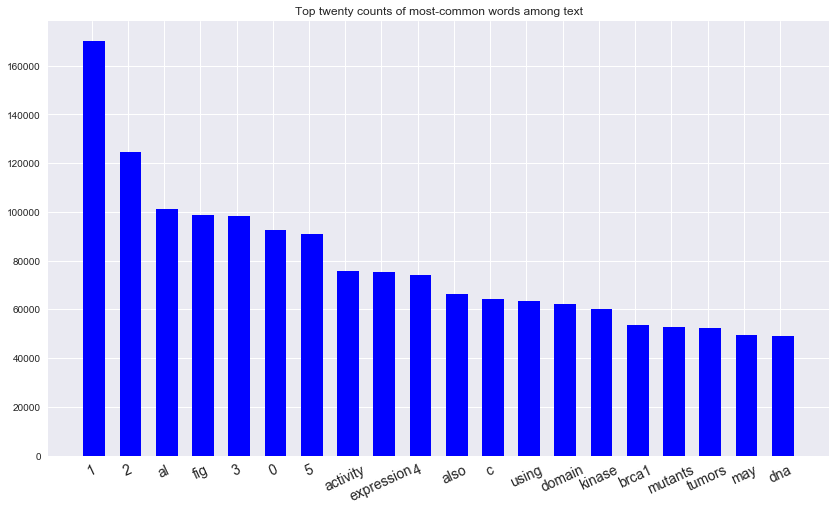

In [47]:
tops = Counter(str(trainText).split()).most_common()[:20]
labs, vals = zip(*tops)
idx = np.arange(len(labs))
wid=0.6

fig, ax = plt.subplots(1,1,figsize=(14,8))
ax = plt.bar(idx, vals, wid, color='b')
ax = plt.xticks(idx - wid/8, labs, rotation=25, size=14)
plt.title('Top twenty counts of most-common words among text')
plt.show()

In [48]:
gc.collect()

293

This plot is left skewed. More filtering should be done. 

In [8]:
topInc = Counter(str(trainText).split()).most_common()[:30]
labsInc, valsInc = zip(*topInc)

In [9]:
def stopCheck(text, stops):
    text = text.split()
#     stops = {'mutations', 'cancer'}
    text = [w for w in text if not w in stops]    
    text = " ".join(text)
    return text

In [10]:
trainText2 = []
for it in trainText:
    newText = stopCheck(it, labsInc)
    trainText2.append(newText)
testText2 = []
for it in testText:
    newText = stopCheck(it, labsInc)
    testText2.append(newText)

In [11]:
gc.collect()

301

In [12]:
trainText2[2][:100]

'abstract background non-small lung nsclc heterogeneous group disorders number genetic proteomic alte'

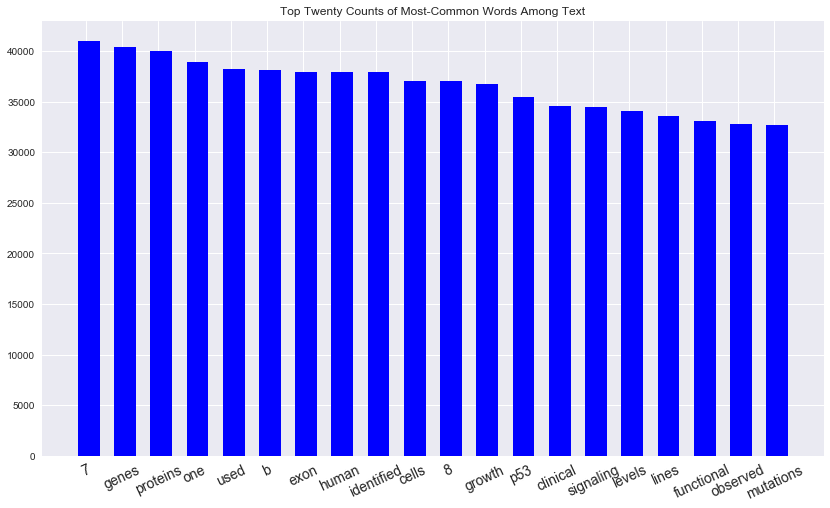

In [13]:
tops = Counter(str(trainText2).split()).most_common()[:20]
labs, vals = zip(*tops)
idx = np.arange(len(labs))
wid = 0.6

fig, ax = plt.subplots(1,1,figsize=(14,8))
ax = plt.bar(idx, vals, wid, color='b')
ax = plt.xticks(idx - wid/8, labs, rotation=25, size=14)
plt.title('Top Twenty Counts of Most-Common Words Among Text')
plt.show()

In [14]:
gc.collect()

214

In [15]:
maxFeats=500

In [16]:
tfidf = TfidfVectorizer(min_df=5, max_features=maxFeats, ngram_range=(1,3),\
                        strip_accents='unicode', lowercase = True,\
                        analyzer='word', token_pattern=r'\w+',\
                        use_idf=True, smooth_idf=True, sublinear_tf=True,
                        stop_words='english')

In [17]:
tfidf.fit(trainText2)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=5,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=True,
        token_pattern='\\w+', tokenizer=None, use_idf=True,
        vocabulary=None)

In [18]:
countVec = CountVectorizer(min_df=5, ngram_range=(1,3), max_features=maxFeats, 
                           strip_accents='unicode',lowercase =True, 
                           analyzer='word', token_pattern=r'\w+',
                           stop_words = 'english')

In [19]:
countVec.fit(trainText2)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=5,
        ngram_range=(1, 3), preprocessor=None, stop_words='english',
        strip_accents='unicode', token_pattern='\\w+', tokenizer=None,
        vocabulary=None)

In [21]:
len(trainText2)

3321

In [22]:
svd = TruncatedSVD(n_components=390)
svdFit = svd.fit_transform(tfidf.transform(trainText2))

### Feature Building

In [111]:
def buildFeats(texts, variations):
    temp = variations.copy()
    print('Encoding...')
    temp['Gene'] = pd.factorize(variations['Gene'])[0]
    temp['Variation'] = pd.factorize(variations['Variation'])[0]
    temp['Gene_to_Variation_Ratio'] = temp['Gene']/temp['Variation']
    
    print('Lengths...')
    temp['doc_len'] = [len(x) for x in texts]
    temp['unique_words'] = [len(set(x))  for x in texts]
    
    print('TFIDF...')
    temp_tfidf = tfidf.transform(texts)
    temp['tfidf_sum'] = temp_tfidf.sum(axis=1)
    temp['tfidf_mean'] = temp_tfidf.mean(axis=1)
    temp['tfidf_len'] =  (temp_tfidf != 0).sum(axis = 1)
    
    print('Count Vecs...')
    temp_cvec = countVec.transform(texts)
    temp['cvec_sum'] = temp_cvec.sum(axis=1)
    temp['cvec_mean'] = temp_cvec.mean(axis=1)
    temp['cvec_len'] =  (temp_cvec != 0).sum(axis = 1)
    
    print('Latent Semantic Analysis Cols...')
    tempc = list(temp.columns)
    temp_lsa = svd.transform(temp_tfidf)
    
    for i in range(np.shape(temp_lsa)[1]):
        tempc.append('lsa'+str(i+1))
    temp = pd.concat([temp, pd.DataFrame(temp_lsa, index=temp.index)], axis=1)
    
    return temp, tempc

In [34]:
#temp = train_variants_df.copy()

In [43]:
#temp['Gene']=pd.factorize(train_variants_df['Gene'])[0]
#temp['Variation']=pd.factorize(train_variants_df['Variation'])[0]
#temp['Gene_to_Variation_Ratio']=temp['Gene']/temp['Variation']

In [51]:
#temp['doc_len'] = [len(x) for x in trainText2]
#temp['unique_words'] = [len(set(x))  for x in trainText2]

In [60]:
#temp_tfidf = tfidf.transform(trainText2)

In [80]:
#temp['tfidf_sum'] = temp_tfidf.sum(axis=1)
#temp_tfidf.sum(axis=1)

In [81]:
#temp['tfidf_mean'] = temp_tfidf.mean(axis=1)

In [82]:
#temp['tfidf_len'] =  (temp_tfidf != 0).sum(axis = 1)

In [84]:
#temp_cvec = countVec.transform(trainText2)

In [85]:
#temp['cvec_sum'] = temp_cvec.sum(axis=1)
#temp['cvec_mean'] = temp_cvec.mean(axis=1)
#temp['cvec_len'] =  (temp_cvec != 0).sum(axis = 1)

In [106]:
#tempc = list(temp.columns)

In [107]:
#temp_lsa = svd.transform(temp_tfidf)

In [108]:
#for i in range(np.shape(temp_lsa)[1]):
#    tempc.append('lsa'+str(i+1))
#temp = pd.concat([temp, pd.DataFrame(temp_lsa, index=temp.index)], axis=1)

In [109]:
#type(temp_lsa)

numpy.ndarray

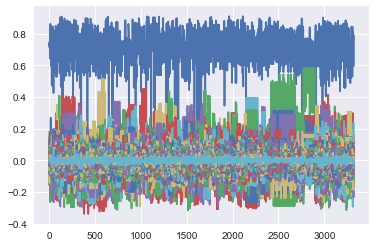

In [97]:
#plt.plot(temp_lsa)
#plt.show()

In [113]:
#temp.head()

,ID,Gene,Variation,Class,Gene_to_Variation_Ratio,doc_len,unique_words,tfidf_sum,tfidf_mean,tfidf_len,...,380,381,382,383,384,385,386,387,388,389
0,0,0,0,1,NaN,27742,43,15.479145,0.030958,305,...,-0.031567,0.020757,0.001611,0.004169,0.011957,-0.010338,0.006910,-0.020910,0.007460,0.005021
1,1,1,1,2,1.000000,23626,44,15.919710,0.031839,314,...,0.008647,0.000134,0.006842,0.003872,0.012711,-0.016750,-0.003077,0.017607,0.006221,-0.004935
2,2,1,2,2,0.500000,23626,44,15.919710,0.031839,314,...,0.008647,0.000134,0.006842,0.003872,0.012711,-0.016750,-0.003077,0.017607,0.006221,-0.004935
3,3,1,3,3,0.333333,24920,44,15.436155,0.030872,308,...,-0.003391,0.007195,-0.005995,-0.003933,0.000632,0.000774,0.001252,0.000685,0.009230,-0.004506
4,4,1,4,4,0.250000,26611,44,15.619500,0.031239,294,...,0.000272,-0.004433,-0.000828,0.002199,-0.001194,-0.002328,0.002200,-0.003783,-0.003747,-0.002703


In [112]:
trainDF, trainCol = buildFeats(trainText2, train_variants_df)
testDF, testCol = buildFeats(testText2, test_variants_df)

Encoding...
Lengths...
TFIDF...
Count Vecs...
Latent Semantic Analysis Cols...
Encoding...
Lengths...
TFIDF...
Count Vecs...
Latent Semantic Analysis Cols...


In [115]:
testDF.head()

,ID,Gene,Variation,Gene_to_Variation_Ratio,doc_len,unique_words,tfidf_sum,tfidf_mean,tfidf_len,cvec_sum,...,380,381,382,383,384,385,386,387,388,389
0,0,0,0,NaN,33652,45,16.891668,0.033783,368,1763,...,0.002096,-0.026938,-0.016727,-0.019444,-0.010331,-0.000718,-0.031463,0.017925,0.007880,-0.007972
1,1,1,1,1.0,22778,42,15.033568,0.030067,283,1068,...,0.014255,0.006223,0.019061,0.012094,-0.032391,0.007743,-0.021799,-0.025197,0.006216,-0.049231
2,2,2,2,1.0,53692,45,17.519918,0.035040,388,2742,...,0.013900,-0.007405,0.002618,0.023035,-0.012375,0.002081,-0.010538,0.018027,-0.007248,0.015001
3,3,3,3,1.0,37516,42,16.546102,0.033092,374,2222,...,-0.016152,0.007275,0.011083,-0.005768,0.015564,0.000572,-0.030275,-0.021535,0.020108,0.004414
4,4,4,4,1.0,55038,44,18.608359,0.037217,407,2457,...,-0.033481,-0.012061,-0.014682,0.019903,0.009680,-0.002074,-0.010992,0.007811,0.011039,0.008546


In [117]:
type(trainCol)

list

In [118]:
trainDF.columns = trainCol
testDF.columns = testCol

In [119]:
trainDF.head()

,ID,Gene,Variation,Class,Gene_to_Variation_Ratio,doc_len,unique_words,tfidf_sum,tfidf_mean,tfidf_len,...,lsa381,lsa382,lsa383,lsa384,lsa385,lsa386,lsa387,lsa388,lsa389,lsa390
0,0,0,0,1,NaN,27742,43,15.479145,0.030958,305,...,-0.031567,0.020757,0.001611,0.004169,0.011957,-0.010338,0.006910,-0.020910,0.007460,0.005021
1,1,1,1,2,1.000000,23626,44,15.919710,0.031839,314,...,0.008647,0.000134,0.006842,0.003872,0.012711,-0.016750,-0.003077,0.017607,0.006221,-0.004935
2,2,1,2,2,0.500000,23626,44,15.919710,0.031839,314,...,0.008647,0.000134,0.006842,0.003872,0.012711,-0.016750,-0.003077,0.017607,0.006221,-0.004935
3,3,1,3,3,0.333333,24920,44,15.436155,0.030872,308,...,-0.003391,0.007195,-0.005995,-0.003933,0.000632,0.000774,0.001252,0.000685,0.009230,-0.004506
4,4,1,4,4,0.250000,26611,44,15.619500,0.031239,294,...,0.000272,-0.004433,-0.000828,0.002199,-0.001194,-0.002328,0.002200,-0.003783,-0.003747,-0.002703


In [121]:
classes = train_variants_df.Class - 1 #python indexing starts from 0
print('Original:', Counter(train_variants_df.Class), '\n ReHashed: ', Counter(classes))

Original: Counter({7: 953, 4: 686, 1: 568, 2: 452, 6: 275, 5: 242, 3: 89, 9: 37, 8: 19}) 
 ReHashed:  Counter({6: 953, 3: 686, 0: 568, 1: 452, 5: 275, 4: 242, 2: 89, 8: 37, 7: 19})


In [122]:
X_train, X_test, y_train, y_test = train_test_split(trainDF.drop(['ID','Class'],\
                                                                 axis=1),
                                    classes,
                                    test_size = 0.1,
                                    random_state=31415)
print(np.shape(X_train))

(2988, 401)


In [130]:
print('Format a Train and Test Set for LGB')
d_train = lgb.Dataset(X_train, label=y_train)
d_val = lgb.Dataset(X_test, label=y_test)
               
gc.collect()

Format a Train and Test Set for LGB


979

In [139]:
parms = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 9,
    'metric': {'multi_logloss'},
    'learning_rate': 0.05, 
    'max_depth': 5,
    'num_iterations': 400, 
    'num_leaves': 95, 
    'min_data_in_leaf': 60, 
    'lambda_l1': 1.0,
    'feature_fraction': 0.8, 
    'bagging_fraction': 0.8, 
    'bagging_freq': 5}

rnds = 260
mod = lgb.train(parms, train_set=d_train, num_boost_round=rnds,
               valid_sets=[d_val], valid_names=['dval'], verbose_eval=20,
               early_stopping_rounds=20)

Training until validation scores don't improve for 20 rounds.
[20]	dval's multi_logloss: 1.50092
[40]	dval's multi_logloss: 1.25825
[60]	dval's multi_logloss: 1.14163
[80]	dval's multi_logloss: 1.07396
[100]	dval's multi_logloss: 1.03861
[120]	dval's multi_logloss: 1.01131
[140]	dval's multi_logloss: 0.99497
[160]	dval's multi_logloss: 0.984454
[180]	dval's multi_logloss: 0.980776
[200]	dval's multi_logloss: 0.981886
Early stopping, best iteration is:
[194]	dval's multi_logloss: 0.979542


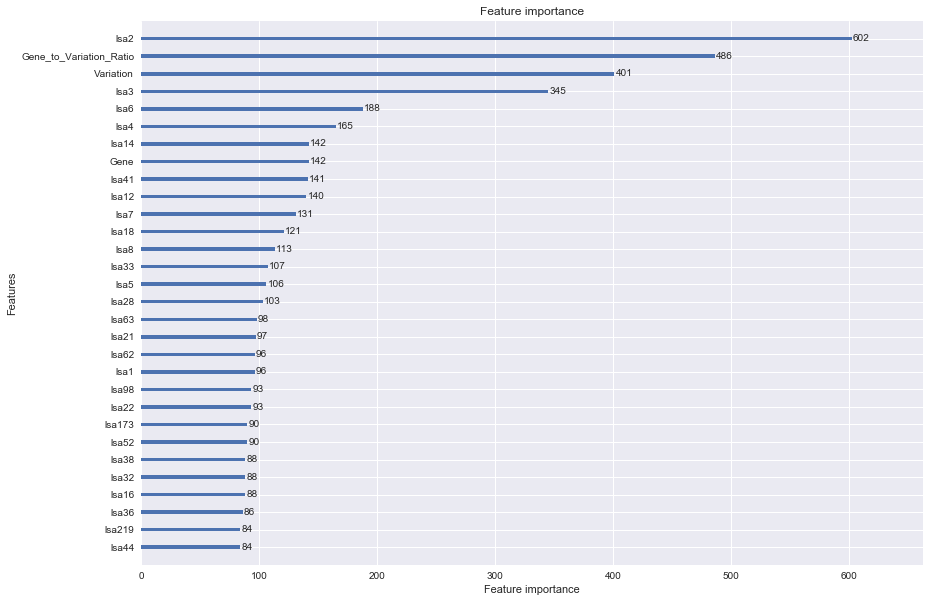

In [137]:
lgb.plot_importance(mod, max_num_features=30, figsize=(14,10))

In [126]:
pred = mod.predict(testDF.drop(['ID'],axis=1))

In [128]:
mod.best_score

defaultdict(dict, {'dval': {'multi_logloss': 0.97954212684536335}})

In [129]:
mod.best_iteration

194

In [71]:
sub = pd.DataFrame(pred, index=testDF.index)
sub.head()

,0,1,2,3,4,5,6,7,8
0,0.490867,0.199684,0.002631,0.012248,0.009235,0.014245,0.258453,0.001670,0.010968
1,0.471032,0.211481,0.004319,0.219037,0.011665,0.021940,0.051701,0.006299,0.002526
2,0.189086,0.411576,0.045234,0.085233,0.015071,0.023058,0.216151,0.011308,0.003284
3,0.146030,0.502169,0.009970,0.039653,0.013439,0.012590,0.266772,0.006167,0.003210
4,0.575600,0.123042,0.005288,0.193116,0.015322,0.015443,0.060949,0.006105,0.005135


In [69]:
sub.shape

(5668, 9)